## 3. Análise Exploratória dos Dados

Este notebook apresenta uma breve análise exploratória da base de dados extraída para modelagem. Aqui foi priorizado identificar possíveis padrões que possam ser úteis nas próximas etapas do projeto.

In [29]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Estatística
import scipy.stats as stats

# Processamento de texto
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
# Carregando dados limpos (resultado da Pré-Tokenização)

data_folder = "../data/final/enem_data.csv"

df_enem = pd.read_csv(data_folder)
df_enem.head()

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...


In [31]:
# renomeando parâmetro relacionado a dificuldade

df = df_enem.rename(columns={"nu_param_B": "dificuldade"})
df.head()

,numero_questao,gabarito,NU_PARAM_A,dificuldade,NU_PARAM_C,ANO,enunciado,alternativas
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...


### 3.1 Funções Utilizadas

In [32]:
# ========== CONFIGURAÇÕES INICIAIS ==========

# Baixar stopwords do NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))


# ========== FUNÇÕES DE ESTATÍSTICA ==========

def max_sem_outlier(group):
    """
    Retorna o valor máximo de um grupo ignorando outliers superiores.
    """
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    return group[group <= limite_superior].max()


# ========== FUNÇÕES DE LIMPEZA DE TEXTO ==========

def clean_text(text):
    """
    Limpa e normaliza o texto:
    - Converte para minúsculas
    - Remove stopwords
    - Remove duplicatas
    - Retorna palavras ordenadas
    """
    if not isinstance(text, str):
        return ""
    
    words = re.findall(r'\b[a-zA-Zà-úÀ-ÚüÜ]+\b', text.lower())
    words = [word for word in words if word not in stop_words]
    return " ".join(sorted(set(words)))


def clean_alternatives(alt_text):
    """
    Processa texto de alternativas mantendo identificadores (A:, B:, etc.)
    e limpando o conteúdo com `clean_text`.
    """
    if not isinstance(alt_text, str):
        return ""
    
    alternatives = re.split(r'(?=[A-E]: )', alt_text)
    cleaned_alts = []

    for alt in alternatives:
        if ": " in alt:
            key, value = alt.split(": ", 1)
            cleaned_value = clean_text(value)
            cleaned_alts.append(f"{key}: {cleaned_value}")

    return "; ".join(cleaned_alts)


# ========== FUNÇÕES DE VISUALIZAÇÃO ==========

def get_wordcloud(df, col, max_words=100):
    """
    Gera nuvens de palavras separadas por dificuldade, com frequência independente:
    - Todos os enunciados
    - Alta dificuldade
    - Baixa dificuldade
    """
    df_counter = df.dropna(subset=[col])
    median_dif = df_counter['dificuldade'].median()

    # Textos por grupo
    text_total = ' '.join(df_counter[col])
    text_hard = ' '.join(df_counter[df_counter['dificuldade'] > median_dif][col])
    text_easy = ' '.join(df_counter[df_counter['dificuldade'] <= median_dif][col])

    # Gera nuvens com frequência específica de cada grupo
    wordcloud_total = WordCloud(width=600, height=300, background_color='white',
                                max_words=max_words).generate(text_total)

    wordcloud_hard = WordCloud(width=600, height=300, background_color='white',
                               max_words=max_words).generate(text_hard)

    wordcloud_easy = WordCloud(width=600, height=300, background_color='white',
                               max_words=max_words).generate(text_easy)

    # Plotar
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(wordcloud_total, interpolation='bilinear')
    axes[0].set_title('Todos os Enunciados', fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(wordcloud_hard, interpolation='bilinear')
    axes[1].set_title(f'Maior Dificuldade ( > {median_dif:.2f})', fontsize=12)
    axes[1].axis('off')

    axes[2].imshow(wordcloud_easy, interpolation='bilinear')
    axes[2].set_title(f'Menor Dificuldade ( ≤ {median_dif:.2f})', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def get_word_frequencies(df, col, top_n=10):
    """
    Gera histogramas horizontais com as palavras mais frequentes
    separadas por dificuldade:
    - Todos os enunciados
    - Alta dificuldade
    - Baixa dificuldade
    """
    df_counter = df.dropna(subset=[col])
    median_dif = df_counter['dificuldade'].median()

    # Divide os textos
    text_total = df_counter[col]
    text_hard = df_counter[df_counter['dificuldade'] > median_dif][col]
    text_easy = df_counter[df_counter['dificuldade'] <= median_dif][col]

    def get_top_words(text_series, n):
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(text_series)
        word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum()
        return word_counts.sort_values(ascending=False).head(n)

    # Frequências separadas por grupo
    top_total = get_top_words(text_total, top_n)
    top_hard = get_top_words(text_hard, top_n)
    top_easy = get_top_words(text_easy, top_n)

    # Plotar histogramas
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].barh(top_total.index[::-1], top_total.values[::-1], color='skyblue')
    axes[0].set_title('Todos os Enunciados')

    axes[1].barh(top_hard.index[::-1], top_hard.values[::-1], color='salmon')
    axes[1].set_title(f'Maior Dificuldade ( > {median_dif:.2f})')

    axes[2].barh(top_easy.index[::-1], top_easy.values[::-1], color='lightgreen')
    axes[2].set_title(f'Menor Dificuldade ( ≤ {median_dif:.2f})')

    for ax in axes:
        ax.set_xlabel('Frequência')
        ax.grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 3.2 Análise Preliminar

Dado que `nu_param_B` (aka. `dificuldade`, por aqui) é a variável target, desnecessário focar em questões em que esta não foi calculada

In [33]:
# verificando existência de valores nulos

df.isna().sum()

numero_questao    0
gabarito          0
NU_PARAM_A        3
dificuldade       3
NU_PARAM_C        3
ANO               0
enunciado         0
alternativas      0
dtype: int64

In [34]:
# removendo valores nulos

df = df[df['dificuldade'].notna()]

In [35]:
# breve visualização das medidas numéricas

df.describe()

,numero_questao,NU_PARAM_A,dificuldade,NU_PARAM_C,ANO
count,312.000000,312.000000,312.000000,312.000000,312.000000
mean,61.416667,2.341498,1.107819,0.160293,2020.000000
std,20.478821,1.033068,0.703195,0.066480,2.008022
min,1.000000,0.473870,-0.726450,0.001610,2017.000000
25%,51.000000,1.590278,0.629692,0.120085,2018.000000
50%,64.000000,2.198110,1.062395,0.165600,2020.000000
75%,77.000000,2.998242,1.565068,0.200033,2022.000000
max,90.000000,6.694280,3.517780,0.351600,2023.000000


### 3.3 **Análise da Dificuldade**

Text(0, 0.5, 'Frequência')

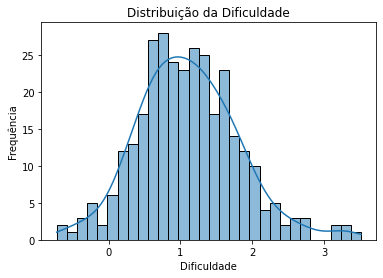

In [36]:
# histograma da dificuldade

sns.histplot(df['dificuldade'], bins=30, kde=True)
plt.title('Distribuição da Dificuldade')
plt.xlabel('Dificuldade')
plt.ylabel('Frequência')

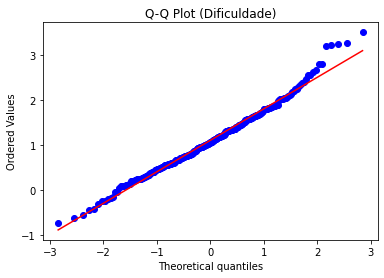

In [37]:
# q-q plot da dificuldade

stats.probplot(df['dificuldade'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Dificuldade)')
plt.show()

In [38]:
# verificando se a dificuldade segue uma distribuição normal

stat, p = stats.shapiro(df[df['dificuldade'].notna()]['dificuldade'])
print(f"Estatística de teste: {stat:.4f} | p-valor: {p:.4f}")

if p > 0.05:
    print("Não rejeita H_0: distribuição normal.")
else:
    print("Rejeita H_0: exclui distribuição normal.")


Estatística de teste: 0.9867 | p-valor: 0.0057
Rejeita H_0: exclui distribuição normal.


Com a exclusão da distribuição normal, necessário o grupo se atentar se o modelo de predição possui sensibilidade à distribuição. 

Caso seja, possível aplicar Box-Cox.

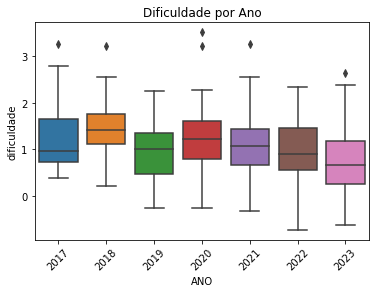

In [39]:
# boxplot da dificuldade por ano

sns.boxplot(x='ANO', y='dificuldade', data=df, order=sorted(df["ANO"].unique()))
plt.title('Dificuldade por Ano')
plt.xticks(rotation=45)

plt.show()

In [40]:
# valores máximos das dificuldades por ano

max_por_ano = df.groupby('ANO')['dificuldade'].apply(max_sem_outlier)
max_por_ano

ANO
2017    2.80277
2018    2.55364
2019    2.25728
2020    2.28546
2021    2.56419
2022    2.33974
2023    2.37904
Name: dificuldade, dtype: float64

O corte de dificuldade 3, feito no artigo, não parece de todo arbitrário.

Afinal, na maioria dos anos, o máximo de dificuldade (excluídos os outliers) não ultrapassa 3 frequentemente. Como sugestão, possível utilizar o corte do máximo da lista (ano de 2013, com 3.38570)

### 3.4 **Análise dos Enunciados**

In [41]:
# aplicando limpezas nas variáveis textuais

df["enunciado_limpo"] = df["enunciado"].apply(clean_text)
df["alternativas_limpo"] = df["alternativas"].apply(clean_alternatives)

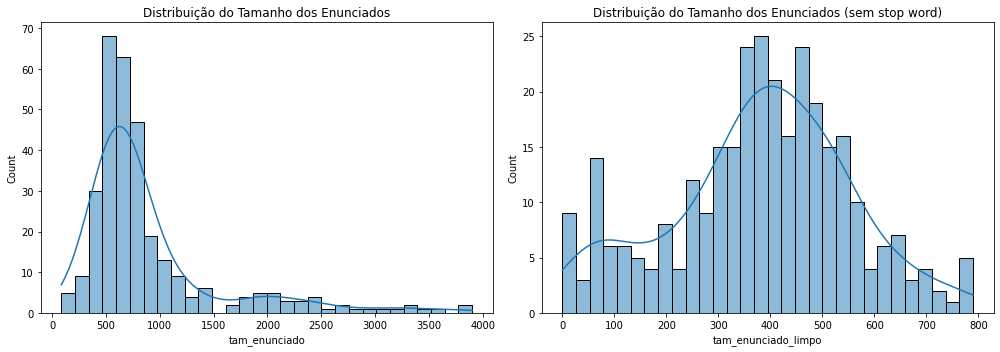

In [42]:
# visualizando o histograma da variável de enunciado pelo tamanho do mesmo 

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['tam_enunciado'] = df['enunciado'].str.len()
df['tam_enunciado_limpo'] = df['enunciado_limpo'].str.len()

sns.histplot(df['tam_enunciado'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribuição do Tamanho dos Enunciados')

sns.histplot(df['tam_enunciado_limpo'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribuição do Tamanho dos Enunciados (sem stop word)')

plt.tight_layout()
plt.show()

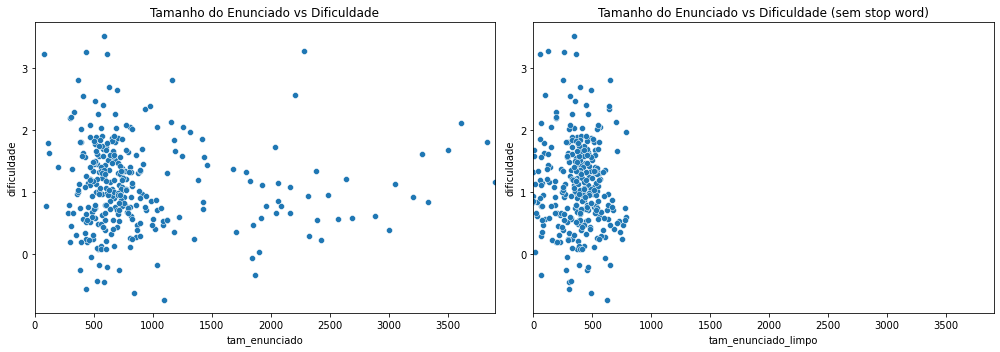

In [43]:
# scatterplot do tamanho do enunciado vs dificuldade

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='tam_enunciado', y='dificuldade', data=df, ax=axes[0])
axes[0].set_title('Tamanho do Enunciado vs Dificuldade')

sns.scatterplot(x='tam_enunciado_limpo', y='dificuldade', data=df, ax=axes[1])
axes[1].set_title('Tamanho do Enunciado vs Dificuldade (sem stop word)')

x_min = df['tam_enunciado_limpo'].min()
x_max = df['tam_enunciado'].max()
axes[0].set_xlim(x_min, x_max)
axes[1].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

Não se verifica um correlação direta entre o tamanho do enunciado e a dificuldade da questão, muito embora se verifique uma pequena concentração entre 0 e 2 nos menores enunciados.

### 3.5 **Análise de Gabarito**

<Axes: title={'center': 'Distribuição de Alternativas Corretas'}>

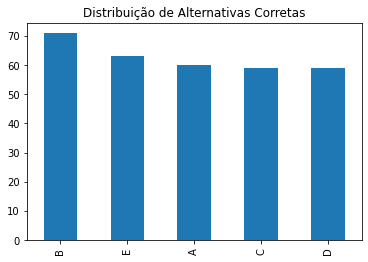

In [44]:
# frequência em que cada opção do gabarito foi correta

df['gabarito'].value_counts().plot(kind='bar', title='Distribuição de Alternativas Corretas')

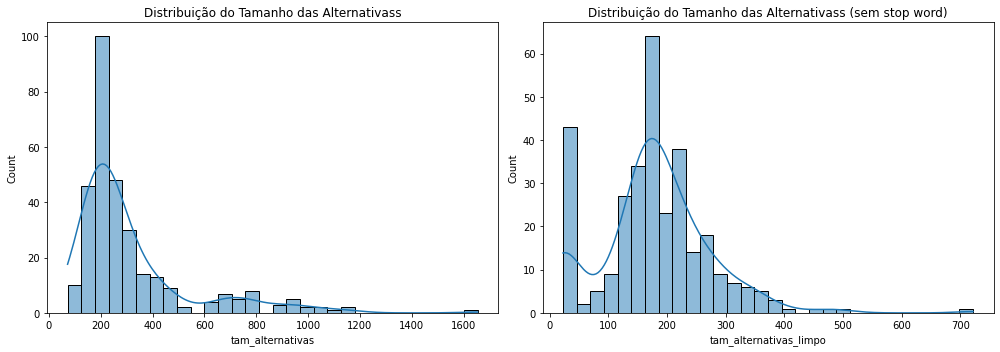

In [45]:
# distribuições dos tamanhos das alternativas possíveis

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['tam_alternativas'] = df['alternativas'].str.len()
df['tam_alternativas_limpo'] = df['alternativas_limpo'].str.len()

sns.histplot(df['tam_alternativas'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribuição do Tamanho das Alternativass')

sns.histplot(df['tam_alternativas_limpo'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribuição do Tamanho das Alternativass (sem stop word)')

plt.tight_layout()
plt.show()

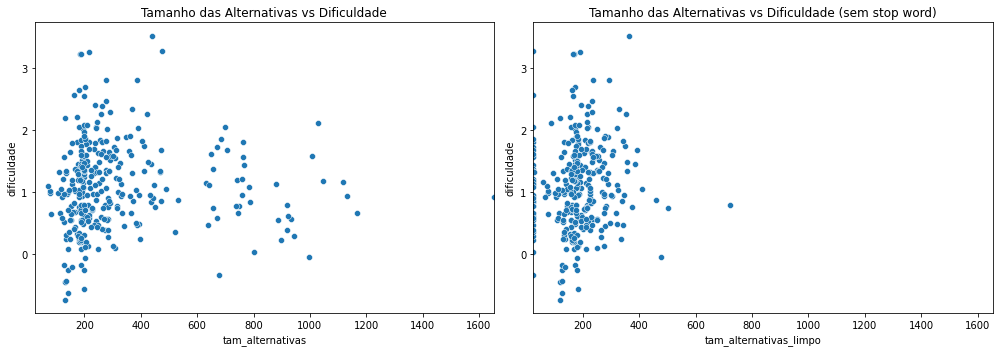

In [46]:
# relação entre alternativa e dificuldade

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='tam_alternativas', y='dificuldade', data=df, ax=axes[0])
axes[0].set_title('Tamanho das Alternativas vs Dificuldade')

sns.scatterplot(x='tam_alternativas_limpo', y='dificuldade', data=df, ax=axes[1])
axes[1].set_title('Tamanho das Alternativas vs Dificuldade (sem stop word)')

x_min = df['tam_alternativas_limpo'].min()
x_max = df['tam_alternativas'].max()
axes[0].set_xlim(x_min, x_max)
axes[1].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

### 3.6 WordCloud e Frequências (Gabarito e Alternativas)

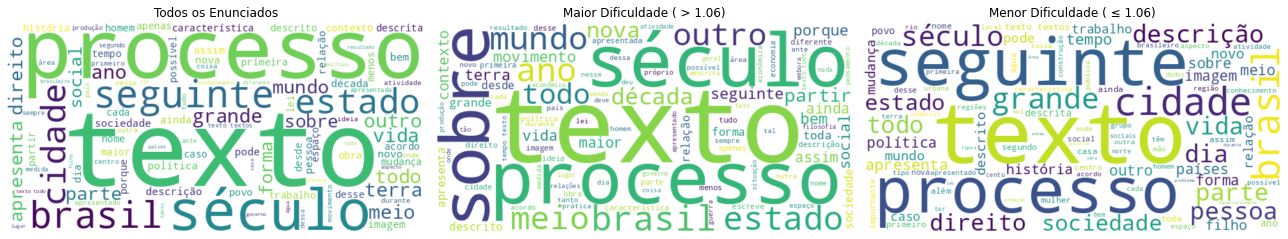

In [47]:
get_wordcloud(df, "enunciado_limpo")

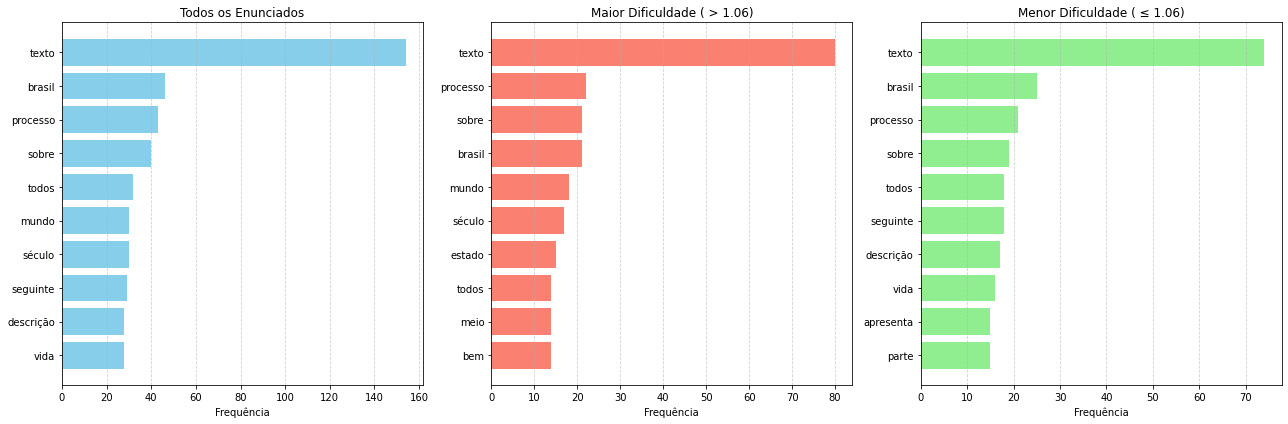

In [48]:
get_word_frequencies(df, "enunciado_limpo")

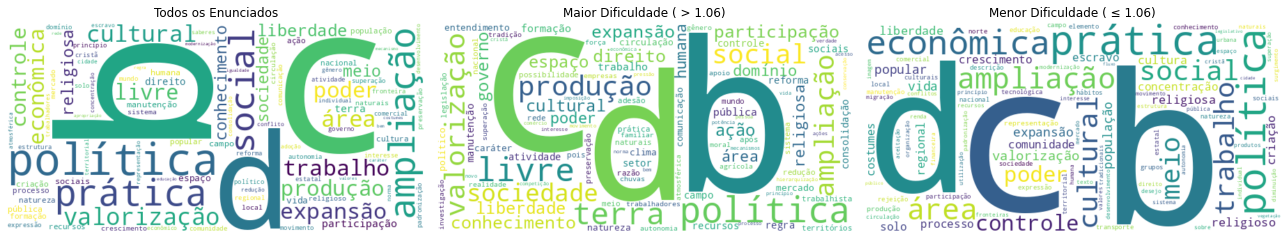

In [49]:
df['alternativas_adap'] = df['alternativas_limpo'].dropna().str.replace(r'[A-E]:\s*', '', regex=True)

get_wordcloud(df, "alternativas_adap")

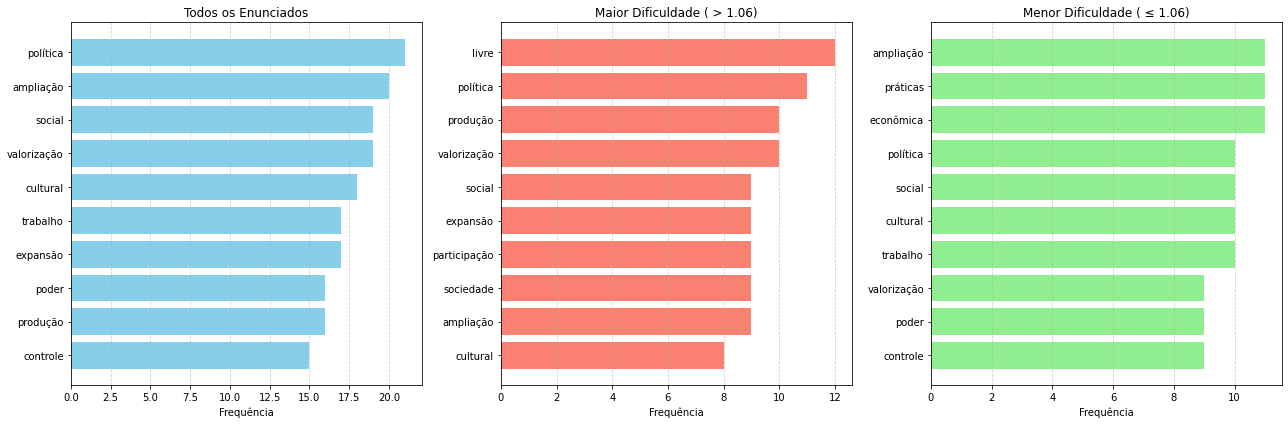

In [50]:
get_word_frequencies(df, "alternativas_adap")